In [78]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


import pickle

from tqdm import tqdm
import os



In [79]:
import scipy as sp
target = sp.genfromtxt('SMSSpamCollection.csv', delimiter=",", usecols=(0), dtype=str, skip_header=1)
target_ids = np.unique(target)
#Afficher les étiquettes "ids"
print(target_ids)

['ham' 'ham"""' 'spam']


In [80]:
#Lire le fichier SMSSpamCollection

data=pd.read_csv('SMSSpamCollection.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [81]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)#retirer les données non nécessaires
#renommer les colonnes label et message par v1 et v2 qu'on a rajouté à SMSSpamCollection 
data = data.rename(columns={"v1":"label", "v2":"message"})
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [82]:
#Combien de messages sont ham et spam
data['label'].value_counts()


ham     4825
spam     747
Name: label, dtype: int64

In [47]:
#Changement des valeurs ham: 1 et spam : 0
def partition(x):
    if x=='ham':
        return 1
    else:
        return 0

actualScore=data['label']
hamSpam=actualScore.map(partition)
data['label']=hamSpam
data.head()


,label,message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [48]:
#retirer "stop words" (les mots vides) et Data Cleaning
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [49]:
# Tous les "stop words"
# On retire tous les mots de la liste de "stop words": 'no', 'nor', 'not'
# <br /><br /> ==> après les etapes suivantes on obtient "br br"
# On les ajoute dans la liste de "stop words"
# à la place de <br /> si on a <br/> ces tags auraient été retiré dans la 1ère etape


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [50]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_message = []

# tqdm c'est pour "print" le status bar

for sentance in tqdm(data['message'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_message.append(sentance.strip()) 

100%|██████████| 5572/5572 [00:07<00:00, 776.77it/s] 


In [51]:
preprocessed_message[1000]

'no heard abt tat'

In [52]:
import math
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
# Utilisation de "Multinomial Naive Bayes" pour "Spam Filtering"
# Fonctionnalité "BAG OF WORDS"

# Division les données entre training et test

X=preprocessed_message

y=np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(y_train.shape)
print(y_test.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [53]:
count_vect=CountVectorizer()
X_train=count_vect.fit_transform(X_train)
X_test=count_vect.transform(X_test)

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]# Alpha de 10^-5 à 10^5
cv_scores = []

# Effectuer une "cross validation" 10 fois
for k in alpha_values:
    mnb = MultinomialNB(alpha = k)
    scores = cross_val_score(mnb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# Déterminer la meilleure valeur d'Alpha
optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
print('\nLa valeur optimal de Alpha est %.3f.' % optimal_alpha)


La valeur optimal de Alpha est 10.000.


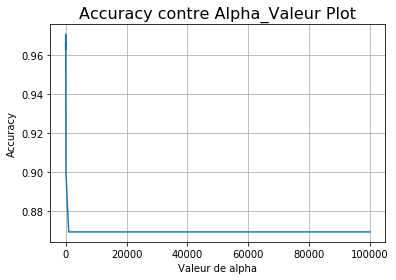



Valeur de alpha :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

Accuracy pour chaque valeur de Alpha est :
  [0.96462 0.96513 0.9659  0.9659  0.96359 0.96257 0.97051 0.89898 0.86949
 0.86949 0.86949]


In [54]:
# On parcelle "Accuracy" contre "Alpha" 
plt.plot(alpha_values, cv_scores)
plt.xlabel('Valeur de alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy contre Alpha_Valeur Plot',size=16)
plt.grid()
plt.show()

print("\n\nValeur de alpha :\n",alpha_values)
print("\nAccuracy pour chaque valeur de Alpha est :\n ", np.round(cv_scores,5))

In [55]:
# instancier le modèle d'apprentissage alpha = optimal_alpha
mnb = MultinomialNB(alpha = optimal_alpha)

# ajustement du modèle
mnb.fit(X_train, y_train)

# prédire la réponse
predictions = mnb.predict(X_test)

# évaluer la précision
acc = accuracy_score(y_test, predictions) * 100
print('\nLe Teste Accuracy de Bernoulli Naive Bayes classifier pour alpha = %.3f is %f%%' % (optimal_alpha, acc))



Le Teste Accuracy de Bernoulli Naive Bayes classifier pour alpha = 10.000 is 96.052632%


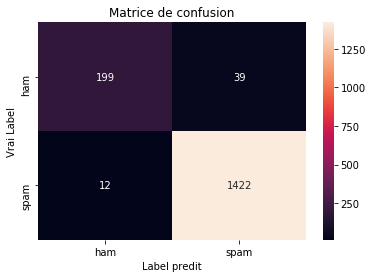

In [64]:
#Matrice de confusion utilisant "heatmap" pour les données de test
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=optimal_alpha)
mnb.fit(X_train,y_train)
predic=mnb.predict(X_test)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["ham", "spam"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Label predit")
plt.ylabel("Vrai Label")
plt.show()

In [59]:
# Essayons pour tfidf


X=preprocessed_message

y=np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tf_idf_vect = TfidfVectorizer(min_df=10)
X_train=tf_idf_vect.fit_transform(X_train)
X_test=tf_idf_vect.transform(X_test)

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]# Alpha de 10^-5 à 10^5
cv_scores = []

# Effectuer une "cross validation" 10 fois
for k in alpha_values:
    mnb = MultinomialNB(alpha = k)
    scores = cross_val_score(mnb, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# déterminer la meilleure valeur de l'Alpha
optimal_alpha = alpha_values[cv_scores.index(max(cv_scores))]
print('\nLe valeur optimal de Alpha est %.3f.' % optimal_alpha)


Le valeur optimal de Alpha est 0.100.


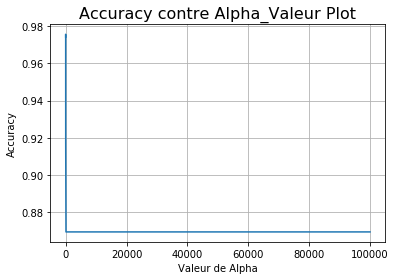



Valeur de Alpha :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

Accuracy pour chaque valeur de Alpha est :
  [0.97411 0.97436 0.97462 0.97539 0.97564 0.97359 0.91693 0.86949 0.86949
 0.86949 0.86949]


In [61]:
# On parcelle "Accuracy" contre "Alpha" 
plt.plot(alpha_values, cv_scores)
plt.xlabel('Valeur de Alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy contre Alpha_Valeur Plot',size=16)
plt.grid()
plt.show()

print("\n\nValeur de Alpha :\n",alpha_values)
print("\nAccuracy pour chaque valeur de Alpha est :\n ", np.round(cv_scores,5))

In [62]:
# instancier le modèle d'apprentissage alpha = optimal_alpha
mnb = MultinomialNB(alpha = optimal_alpha)

# ajustement du modèle
mnb.fit(X_train, y_train)

# prédire la réponse
predictions = mnb.predict(X_test)

# évaluer la précision
acc = accuracy_score(y_test, predictions) * 100
print('\nLe Teste Accuracy de Bernoulli Naive Bayes classifier pour alpha = %.3f is %f%%' % (optimal_alpha, acc))



Le Teste Accuracy de Bernoulli Naive Bayes classifier pour alpha = 0.100 is 96.949761%


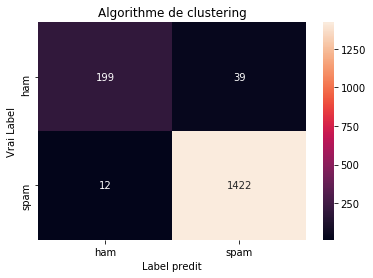

In [65]:
# Matrice de confusion utilisant "heatmap" pour les données de test
from sklearn.metrics import confusion_matrix
mnb=MultinomialNB(alpha=optimal_alpha)
mnb.fit(X_train,y_train)
predic=mnb.predict(X_test)
import seaborn as sns
conf_mat = confusion_matrix(y_test, predic)
class_label = ["ham", "spam"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True,fmt="d")
plt.title("Algorithme de clustering")
plt.xlabel("Label predit")
plt.ylabel("Vrai Label")
plt.show()